## Import Libraries

In [1]:
# general libraries
import os
import git
import numpy as np
import pandas as pd
import seaborn as sns

# hugging face libraries
import evaluate
from datasets import load_dataset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForImageClassification, 
    TrainingArguments, 
    Trainer
)

# pytorch libraries
import torch
from torchvision.transforms import (
    Compose, 
    Normalize,
    Resize,
    ToTensor
)

# scikit-learn libraries
from sklearn.metrics import (
    roc_curve, 
    auc,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# plotting libraries
from  matplotlib import pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

## Load Dataset

In [2]:
dataset_dir = os.path.abspath('../../../../datasets/ISIC-2016')

train_dir = os.path.join(dataset_dir, 'dataset-processed/dataset-models/isic-2016-model-train-fbgt-alpha-1')
test_dir = os.path.join(dataset_dir, 'split/test')

train_ds = load_dataset(train_dir)
val_ds = load_dataset(test_dir)

Resolving data files:   0%|          | 0/4000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Mominul Islam/.cache/huggingface/datasets/imagefolder/isic-2016-model-train-fbgt-alpha-1-3cfff8e40dd4f414/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/379 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/Mominul Islam/.cache/huggingface/datasets/imagefolder/test-7b44c5f507d9e6ed/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# loaded dataset structure
print('train_ds: ', train_ds)
print('val_ds: ', val_ds)

train_ds:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
})
val_ds:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 379
    })
})


In [4]:
# num of training and validation samples
print('Training Samples: ', train_ds['train'].num_rows)
print('Validation Samples: ', val_ds['train'].num_rows)

Training Samples:  4000
Validation Samples:  379


In [5]:
# num of features
train_ds['train'].features['label']

ClassLabel(names=['benign', 'malignant'], id=None)

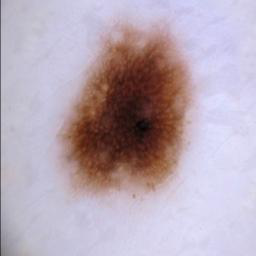

In [6]:
# show image
train_ds['train'][42]['image']

In [7]:
# show label
train_ds['train'][42]['label']

0

In [8]:
# convert labels
labels = train_ds['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [9]:
label2id

{'benign': 0, 'malignant': 1}

In [10]:
id2label

{0: 'benign', 1: 'malignant'}

### Swin Transformer

In [11]:
# download pre-trained model 
path = os.path.abspath('../../../../repository/Swin-Transformer')

if os.path.exists(path):
    print("Folder already exist!")
else:
    os.makedirs(path)
    print("Folder successfully created!")
    git.Git(path).clone('https://huggingface.co/microsoft/swin-tiny-patch4-window7-224')
    print("Repository successfully cloned!")

Folder already exist!


In [12]:
# load pre-trained model 
model_checkpoint = os.path.abspath('../../../../repository/Swin-Transformer/swin-tiny-patch4-window7-224')

# feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# Swin Transformer model
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

C:\Anaconda\anaconda3\envs\csf-model\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at D:\Research\Archive\cossif\repository\Swin-Transformer\swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# number of trainable parameters
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for Swin Transformer model: ', '{0:.6f}'.format(trainable_parameters/1000000), 'million')

Number of trainable parameters for Swin Transformer model:  27.520892 million


In [14]:
# summary of the model
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [15]:
normalize = Normalize(
    mean=feature_extractor.image_mean, 
    std=feature_extractor.image_std
)

train_transform = Compose([
    Resize(feature_extractor.size['height']),
    ToTensor(),
    normalize,
])

val_transform = Compose([
    Resize(feature_extractor.size['height']),
    ToTensor(),
    normalize,
])

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transform(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transform(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [16]:
train_set = train_ds['train']
val_set = val_ds['train']

train_set.set_transform(preprocess_train)
val_set.set_transform(preprocess_val)

In [17]:
model_dir = os.path.abspath('../../../../models/ISIC-2016/Swin-Transformer/isic-2016-swin-fbgt-alpha-1')

In [18]:
batch_size = 24
lr=5e-5
epochs=5

args = TrainingArguments(
    output_dir=os.path.join(model_dir, 'saved_model'),
    remove_unused_columns=False,
    evaluation_strategy = 'steps',
    eval_steps=10,
    save_strategy = 'steps',
    save_steps=10,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    num_train_epochs=epochs,
    optim='adamw_torch',
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='recall',
    save_total_limit=1,
    push_to_hub=False,
    report_to='none'
)

In [19]:
def compute_metrics(eval_pred):
    logits, y_true_flat = eval_pred
    y_pred_flat = np.argmax(logits, axis=1)
    
    TN, FP, FN, TP = confusion_matrix(y_true_flat, y_pred_flat).ravel()
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    
    precision = float('{0:.6f}'.format(precision_score(y_true_flat, y_pred_flat, average='macro')))
    recall = float('{0:.6f}'.format(recall_score(y_true_flat, y_pred_flat, average='macro')))
    f1 = float('{0:.6f}'.format(f1_score(y_true_flat, y_pred_flat, average='macro')))
    accuracy = float('{0:.6f}'.format(accuracy_score(y_true_flat, y_pred_flat)))

    return {'precision': precision, 
            'recall': recall, 
            'f1': f1, 
            'sensitivity': sensitivity, 
            'specificity': specificity,
            'accuracy': accuracy,
            'TN': TN,
            'FP': FP,
            'FN': FN,
            'TP': TP
           }

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Train

In [20]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [21]:
# # train model
# trainer.train()

# # save best model
# save_path = os.path.join(model_dir, 'saved_model')
# trainer.save_model(save_path)

# # save training log
# df = pd.DataFrame(trainer.state.log_history)
# df.to_csv(os.path.join(model_dir, 'training_log.csv'))

## Read CSV

In [22]:
# read training log
df = pd.read_csv(os.path.join(model_dir, 'training_log.csv'))
df = df[['eval_precision', 
         'eval_recall', 
         'eval_f1', 
         'eval_sensitivity', 
         'eval_specificity',
         'eval_accuracy',
         'eval_TN', 
         'eval_FP', 
         'eval_FN', 
         'eval_TP'
        ]].dropna()

# rename columns
df.rename(columns={'eval_precision':'Precision (macro)', 
                   'eval_recall':'Recall (macro)', 
                   'eval_f1':'F1-Score (macro)', 
                   'eval_sensitivity':'Sensitivity', 
                   'eval_specificity':'Specificity', 
                   'eval_accuracy':'Accuracy', 
                   'eval_TN':'TN', 
                   'eval_FP':'FP', 
                   'eval_FN':'FN',
                   'eval_TP':'TP'
                  }, inplace = True)

# convert float to int
df['TN'] = df['TN'].astype(int)
df['FP'] = df['FP'].astype(int)
df['FN'] = df['FN'].astype(int)
df['TP'] = df['TP'].astype(int)

df.head(10)

,Precision (macro),Recall (macro),F1-Score (macro),Sensitivity,Specificity,Accuracy,TN,FP,FN,TP
1,0.563210,0.597610,0.540643,0.586667,0.608553,0.604222,185,119,31,44
3,0.585921,0.564079,0.569625,0.240000,0.888158,0.759894,270,34,57,18
5,0.596722,0.547105,0.548401,0.160000,0.934211,0.781003,284,20,63,12
7,0.659666,0.634035,0.644005,0.373333,0.894737,0.791557,272,32,47,28
9,0.666865,0.702873,0.679243,0.586667,0.819079,0.773087,249,55,31,44
11,0.649239,0.672829,0.658237,0.520000,0.825658,0.765172,251,53,36,39
13,0.699816,0.695768,0.697740,0.506667,0.884868,0.810026,269,35,37,38
15,0.822266,0.643465,0.676811,0.306667,0.980263,0.846966,298,6,52,23
17,0.692065,0.645548,0.661607,0.373333,0.917763,0.810026,279,25,47,28
19,0.690763,0.737851,0.706315,0.653333,0.822368,0.788918,250,54,26,49


In [23]:
# sort training log
df_sort = df.sort_values('Recall (macro)', ascending=False)
df_sort.head(10)

,Precision (macro),Recall (macro),F1-Score (macro),Sensitivity,Specificity,Accuracy,TN,FP,FN,TP
33,0.748036,0.774123,0.759470,0.666667,0.881579,0.839050,268,36,25,50
37,0.763006,0.765636,0.764306,0.626667,0.904605,0.849604,275,29,28,47
29,0.720333,0.764342,0.736785,0.680000,0.848684,0.815303,258,46,24,51
73,0.754777,0.757325,0.756036,0.613333,0.901316,0.844327,274,30,29,46
75,0.768200,0.757237,0.762468,0.600000,0.914474,0.852243,278,26,30,45
77,0.773690,0.753860,0.762977,0.586667,0.921053,0.854881,280,24,31,44
83,0.735293,0.749101,0.741716,0.613333,0.884868,0.831135,269,35,29,46
65,0.759534,0.748925,0.753984,0.586667,0.911184,0.846966,277,27,31,44
31,0.689072,0.747982,0.705395,0.693333,0.802632,0.781003,244,60,23,52
49,0.721269,0.742522,0.730644,0.613333,0.871711,0.820580,265,39,29,46


## Performance Index

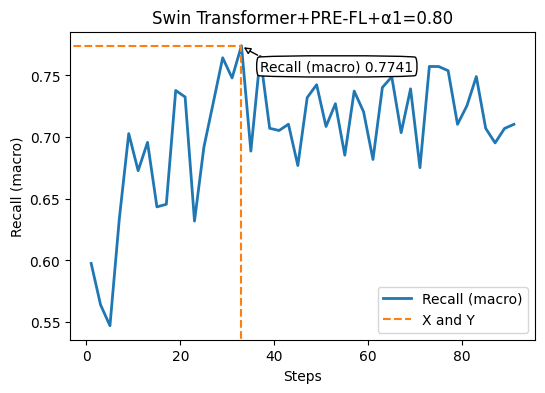

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

x = df['Recall (macro)'].index.values.tolist()
y = df['Recall (macro)'].values.tolist()

# plot AUC 
plt.plot(x, y, lw=2)

# Find the index and coordinates of the highest point
idx = np.argmax(y)
x_max = x[idx]
y_max = y[idx]

xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([x[idx], x[idx], xlim[0]], [xlim[0], y[idx], y[idx]], linestyle="--")
plt.xlim(xlim)
plt.ylim(ylim)

plt.annotate(
    'Recall (macro) {0:.4f}'.format(max(y)), 
    xy=(x_max, y_max), 
    xytext=(x_max + 4, y_max - 0.02),  
    bbox=dict(boxstyle="round4", fc="w"),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3, rad=-0.2", fc="w")
)

plt.title('Swin Transformer+PRE-FL+α1=0.80')
plt.legend(['Recall (macro)', 'X and Y'], loc='lower right')
plt.xlabel('Steps')
plt.ylabel('Recall (macro)')
plt.show()

## Test

In [25]:
save_path = os.path.join(model_dir, 'saved_model')
load_model = save_path

In [26]:
trained_model = AutoModelForImageClassification.from_pretrained(
    load_model, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, 
)

In [27]:
tester = Trainer(
    model=trained_model,
    args=args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [28]:
tester.evaluate()

{'eval_loss': 0.45726343989372253,
 'eval_precision': 0.748036,
 'eval_recall': 0.774123,
 'eval_f1': 0.75947,
 'eval_sensitivity': 0.6666666666666666,
 'eval_specificity': 0.881578947368421,
 'eval_accuracy': 0.83905,
 'eval_TN': 268,
 'eval_FP': 36,
 'eval_FN': 25,
 'eval_TP': 50,
 'eval_runtime': 4.2939,
 'eval_samples_per_second': 88.265,
 'eval_steps_per_second': 3.726}

In [29]:
predictions = tester.predict(test_dataset=val_set).predictions

In [30]:
def to_categorical(y, num_classes):
    """ 1-hot encoding """
    return np.eye(num_classes, dtype='uint8')[y]

def test_set(val_set):
    y = []
    for i in range(val_set.num_rows):
        y.append(val_set[i]['label'])
    return np.array(y)

In [31]:
############## true ##############
# y_true_flat
y_true_flat = test_set(val_set)

# y_true
y_true = to_categorical(y_true_flat, 2)

############## predicted ##############
# y_pred_flat
y_pred_flat = np.argmax(predictions, axis=-1)

# y_pred
y_pred = predictions

In [32]:
############## ROC AUC ##############
neg_cls = 0 # benign
pos_cls = 1 # malignant

print("Positive Class AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true[:, pos_cls], y_pred[:, pos_cls])*100))
print("Negative Class AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true[:, neg_cls], y_pred[:, neg_cls])*100))
print("Average AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true, y_pred)*100))

Positive Class AUC:  81.36%
Negative Class AUC:  82.37%
Average AUC:  81.87%


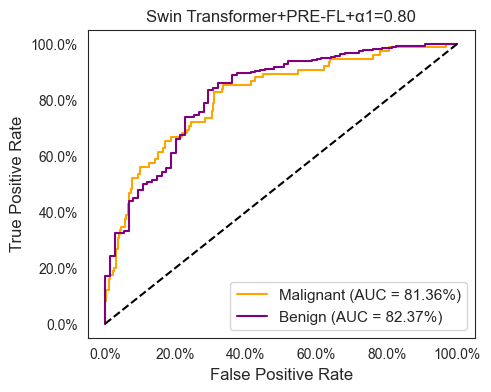

In [33]:
# Set Seaborn style
sns.set_style("white")

fig, ax = plt.subplots(figsize=(5, 4))

# Compute the ROC curve and AUC for each class
fpr_malignant, tpr_malignant, _ = roc_curve(y_true[:, pos_cls], y_pred[:, pos_cls])
auc_malignant = auc(fpr_malignant, tpr_malignant)

fpr_benign, tpr_benign, _ = roc_curve(y_true[:, neg_cls], y_pred[:, neg_cls])
auc_benign = auc(fpr_benign, tpr_benign)

# Plot the ROC curves
ax.plot(fpr_malignant, tpr_malignant, color="orange", label=f"Malignant (AUC = {auc_malignant:.2%})")
ax.plot(fpr_benign, tpr_benign, color="purple", label=f"Benign (AUC = {auc_benign:.2%})")

# Customize the ticks and labels on the axes
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))

# Add the diagonal line, labels, title, and legend
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate", fontsize='12')
plt.ylabel("True Positive Rate", fontsize='12')
plt.title("Swin Transformer+PRE-FL+α1=0.80", fontsize='12')
plt.legend(fontsize='11')
plt.show()

In [34]:
############## Classification Report ##############
targetnames = ['benign', 'malignant']

report = classification_report(y_true_flat, y_pred_flat, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.88      0.90       304
   malignant       0.58      0.67      0.62        75

    accuracy                           0.84       379
   macro avg       0.75      0.77      0.76       379
weighted avg       0.85      0.84      0.84       379



In [35]:
TN, FP, FN, TP = confusion_matrix(y_true_flat, y_pred_flat).ravel()

sensitivity = '{0:.2f}'.format(TP/(TP+FN)*100)
specificity = '{0:.2f}'.format(TN/(TN+FP)*100)
    
precision = '{0:.2f}'.format(precision_score(y_true_flat, y_pred_flat)*100)
recall = '{0:.2f}'.format(recall_score(y_true_flat, y_pred_flat)*100)
f1 = '{0:.2f}'.format(f1_score(y_true_flat, y_pred_flat)*100)
accuracy = '{0:.2f}'.format(accuracy_score(y_true_flat, y_pred_flat)*100)

matrix_log = [[precision, recall, f1, accuracy, sensitivity, specificity, TN, FP, FN, TP]]
df_result = pd.DataFrame(
    matrix_log, 
    columns=[
        'Precision (%)',
        'Recall (%)', 
        'F1-Score (%)',
        'Accuracy (%)', 
        'Sensitivity (%)', 
        'Specificity (%)',
        'TN',
        'FP', 
        'FN', 
        'TP'
    ])

df_result = df_result.style.hide(axis='index')
df_result

Precision (%),Recall (%),F1-Score (%),Accuracy (%),Sensitivity (%),Specificity (%),TN,FP,FN,TP
58.14,66.67,62.11,83.91,66.67,88.16,268,36,25,50


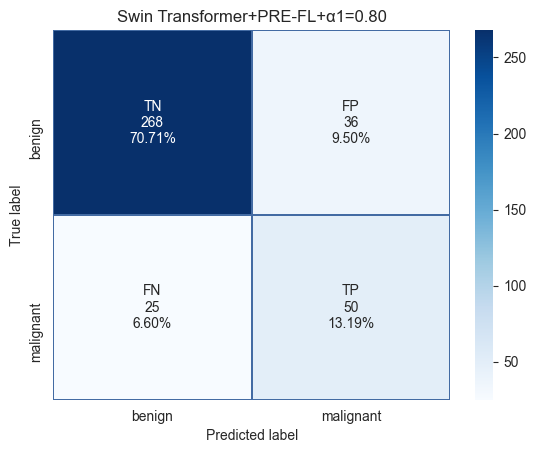

In [36]:
cnf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

matrix_labels = np.asarray(labels).reshape(2,2)
axis_labels = ['benign', 'malignant'] 

ax = sns.heatmap(
    cnf_matrix, 
    annot=matrix_labels, 
    fmt='',  
    cmap='Blues', 
    linewidths=0.1, 
    linecolor=(67/255, 107/255, 163/255),
    xticklabels=axis_labels, 
    yticklabels=axis_labels
)

sns_figure = ax.set(xlabel='Predicted label', ylabel='True label', title='Swin Transformer+PRE-FL+α1=0.80')